In [2]:
import numpy as np
import ot
import cvxpy as cp
import matplotlib.pyplot as plt
import cv2
from utils.Visualizations import *
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# 1D tests for unbalanced

## Normal

In [100]:
n_p = 100
n_q = 100
X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

p = make_1D_gauss(n_p, np.floor(1 * n_p / 4.), 2.) + make_1D_gauss(n_p, np.floor(2 * n_p / 4.), 2.) * (-0.5)
q = make_1D_gauss(n_q, np.floor(5 * n_q / 8.), 2.) + make_1D_gauss(n_q, np.floor(7 * n_q / 8.), 2.) * (-0.5)

C = calculate_costs(n_p)

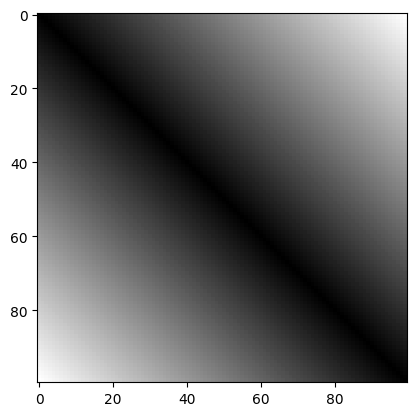

In [101]:
plt.imshow(C, cmap='gray')

In [61]:
## To work with the signed measures
p_pos, p_neg = split_signed_measure(p)
q_pos, q_neg = split_signed_measure(q)

<Figure size 600x600 with 0 Axes>

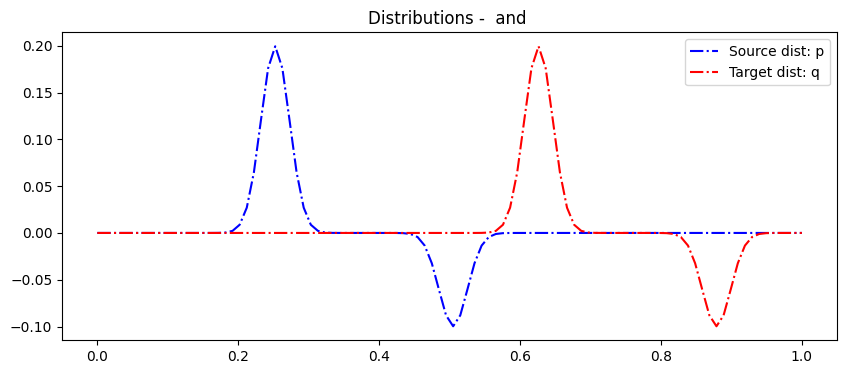

In [62]:
plt.figure(figsize=(6,6))
plot_marginals(X,p,q,'Distributions -  and ')

In [63]:
p_new = p_pos + q_neg
q_new = p_neg + q_pos

<Figure size 600x600 with 0 Axes>

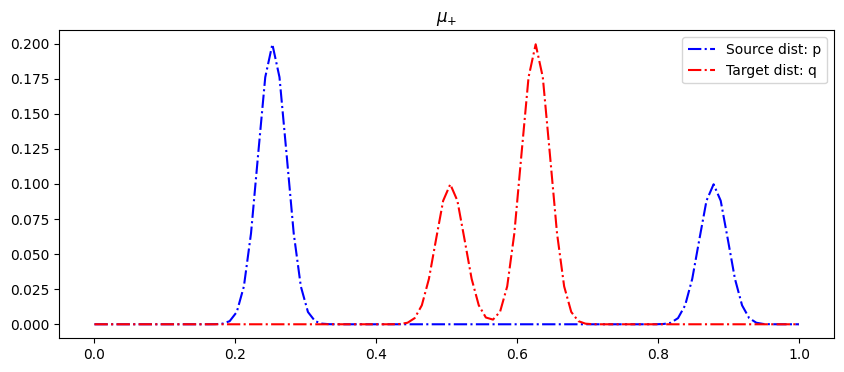

In [64]:
plt.figure(figsize=(6,6))
plot_marginals(X, p_new, q_new, '$\mu_{+}$')

In [65]:
transport_plan, transport_cost = calc_transport_pot_emd(p_new, q_new, C)

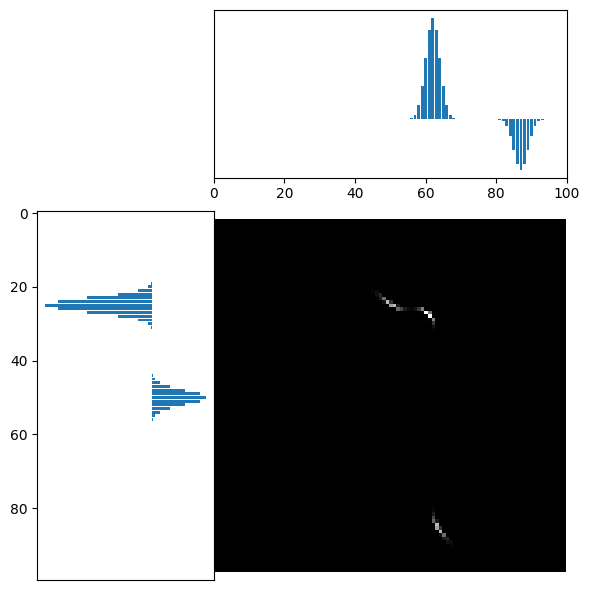

In [66]:
plt.figure(figsize=(6,6))
plot1D_mat_bar(p.flatten(), q.flatten(), transport_plan, '')

## Noised measures

In [67]:
p = make_1D_gauss(n_p, np.floor(1 * n_p / 4.), 2.) + make_1D_gauss(n_p, np.floor(2 * n_p / 4.), 2.) * (-0.5)
q = make_1D_gauss(n_q, np.floor(5 * n_q / 8.), 2.) + make_1D_gauss(n_q, np.floor(7 * n_q / 8.), 2.) * (-0.5)

In [68]:
p_noised = noise_image(p, noise_param=1e-2)
q_noised = noise_image(q, noise_param=1e-2)

<Figure size 600x600 with 0 Axes>

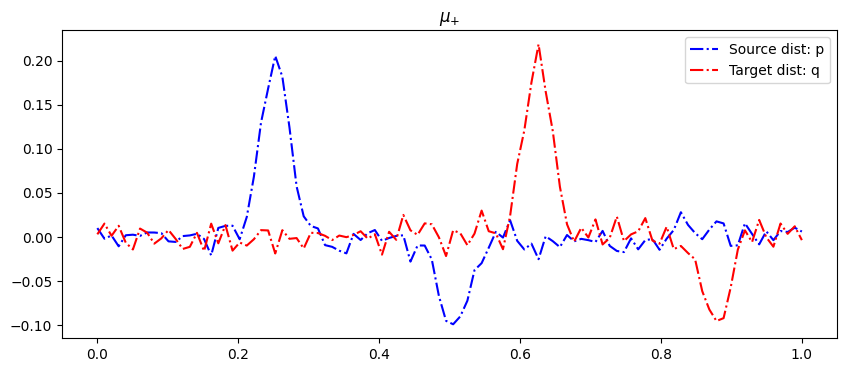

In [69]:
plt.figure(figsize=(6,6))
plot_marginals(X, p_noised, q_noised, '$\mu_{+}$')

In [70]:
p_noised_pos, p_noised_neg = split_signed_measure(p_noised)
q_noised_pos, q_noised_neg = split_signed_measure(q_noised)

p_noised_new = p_noised_pos + q_noised_neg
q_noised_new = p_noised_neg + q_noised_pos

<Figure size 600x600 with 0 Axes>

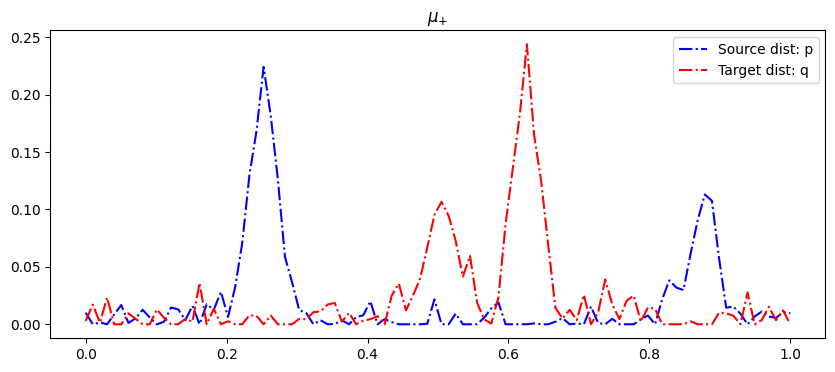

In [71]:
plt.figure(figsize=(6,6))
plot_marginals(X, p_noised_new, q_noised_new, '$\mu_{+}$')

In [72]:
plan_noised_new = ot.unbalanced.mm_unbalanced(a = p_noised_new.flatten(), b = q_noised_new.flatten(), M = C, reg_m = 1)
plan_new = ot.unbalanced.mm_unbalanced(a = p_new.flatten(), b = q_new.flatten(), M = C, reg_m = 1)
# plan_temp = ot.unbalanced.lbfgsb_unbalanced(a = p_noised_new.flatten(), b = q_noised_new.flatten(), M = C, reg = 0, reg_m=0)

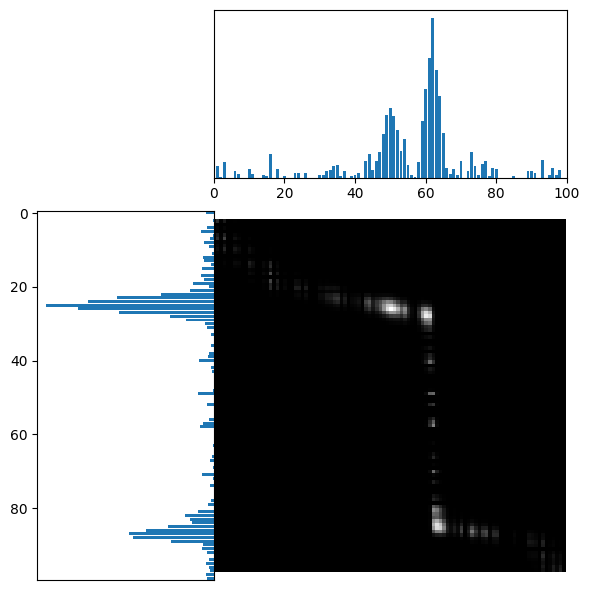

In [74]:
plt.figure(figsize=(6,6))
plot1D_mat_bar(p_noised_new.flatten(), q_noised_new.flatten(), plan_noised_new, '')

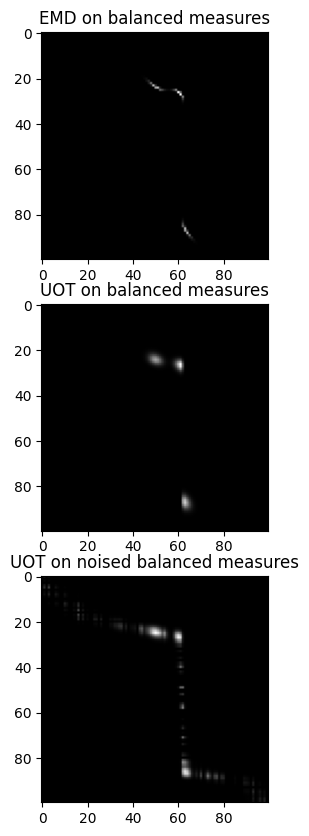

In [75]:
fig = plt.figure(figsize=(6, 10))

fig.add_subplot(3, 1, 1)
plt.title('EMD on balanced measures')
plt.imshow(transport_plan, cmap='gray')

fig.add_subplot(3, 1, 2)
plt.title('UOT on balanced measures')
plt.imshow(plan_new, cmap='gray')

fig.add_subplot(3, 1, 3)
plt.title('UOT on noised balanced measures')
plt.imshow(plan_noised_new, cmap='gray')

Seems like the plan is using some kind of regularization since it does not give the classic EMD solution even when it's used on the same measures. I don't think that it's too critical since we would have probably used the same later on for faster calculations.

# Images

## Functions

In [58]:
def noise_image(im, noise_param = 1e-2):
    """takes an image and makes it noisy"""
    noisy_image = np.copy(im)
    height, width = im.shape
    for i in range(height):
        for j in range(width):
            noisy_image[i,j] += np.random.normal(0, noise_param)

    return noisy_image

In [99]:
def calculate_costs(size):
    """
    This function of an array or image and calculates the cost from it to itself.

    Parameters:
    - `size` (int or 2d array): representing the object on which we would like to calculate costs.

    Returns:
    - `costs` (numpy.ndarray): A 2D array representing the matrix of costs of transporting pixels
                                from the first image to the second image.
    """
    # TODO: Make this more efficient
    # 1D case:
    if type(size) == int:
        # Generate an array of indices from 0 to size-1
        indices = np.arange(size)
        
        # Use broadcasting to calculate the absolute differences between each pair of indices
        costs = np.abs(indices[:, np.newaxis] - indices[np.newaxis, :])
        
        return costs
 
    elif len(size) == 2:
        m, n = size
        size_1d = m * n
        coords = np.array([[i, j] for i in range(m) for j in range(n)])
        delta = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
        delta_sq = delta ** 2
        distances = np.sqrt(np.sum(delta_sq, axis=2)).flatten()
        costs = distances.reshape((size_1d, size_1d))
        return costs

In [5]:
def split_signed_measure(source: np.ndarray) -> (np.ndarray, np.ndarray):
    source_pos: np.ndarray = np.zeros(source.shape)
    source_neg: np.ndarray = np.zeros(source.shape)

    source_pos[source > 0] = source[source > 0]
    source_neg[source < 0] = -source[source < 0]

    return source_pos, source_neg

## 5x5 images

In [179]:
im1 = np.zeros([5,5])
im1[0,0] = 1
im2 = np.zeros([5,5])
im2[3,4] = 1

In [180]:
im1_noisy = noise_image(im1_norm, 5e-2)
im2_noisy = noise_image(im2_norm, 5e-2)

im1_pos, im1_neg = split_signed_measure(im1_noisy.flatten())
im2_pos, im2_neg = split_signed_measure(im2_noisy.flatten())

im1_new = (im1_pos + im2_neg).reshape(im1.shape)
im2_new = (im1_neg + im2_pos).reshape(im2.shape)

In [181]:
C = calculate_costs(im1.shape)

In [217]:
plan = ot.unbalanced.mm_unbalanced(a = im1_new.flatten(), b = im2_new.flatten(), M = C, reg_m = 10)
plan_normal = ot.unbalanced.mm_unbalanced(a = im1.flatten(), b = im2.flatten(), M = C, reg_m = 100)

In [223]:
#Thinking about why the balanced OT plan does not work well.
a = im1.flatten()
b = im2.flatten()
M = C

@interact(reg_m=FloatSlider(min=0.1, max=10.0, step=0.1, value=10), a=fixed(a), b=fixed(b), M=fixed(M))
def interactive_UOT(reg_m=10):
    plan_normal = ot.unbalanced.mm_unbalanced(a=a, b=b, M=M, reg_m=reg_m)
    fig = plt.imshow(plan_normal, cmap='gray')
    plt.title('interactive reg_param')
    plt.colorbar(fig)
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='reg_m', max=10.0, min=0.1), Output()), _dom_classes…

It seems like a small regularization parameter lets us forfeit the fact we need to transport a certain mass. normal transport is done through using a reg_m which is close to infty

In [212]:
np.nonzero(plan_normal)

(array([0], dtype=int64), array([19], dtype=int64))

### Vizualizing

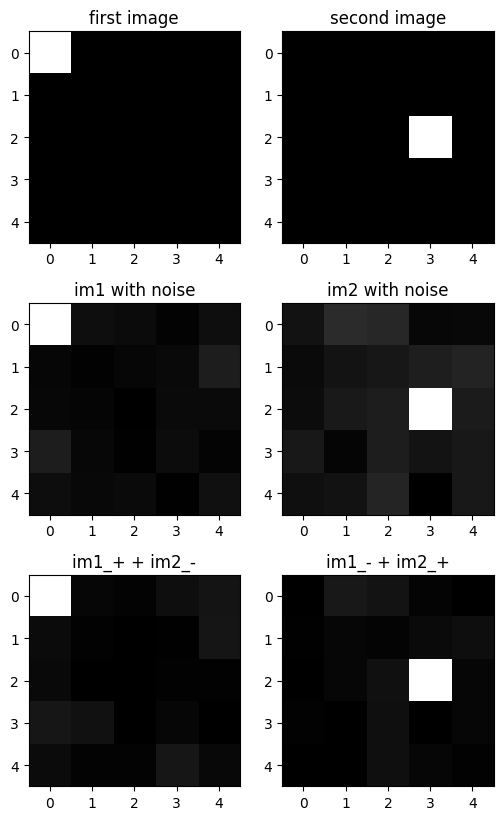

In [155]:
fig = plt.figure(figsize=(6, 10))

fig.add_subplot(3, 2, 1)
plt.title('first image')
plt.imshow(im1, cmap='gray')

fig.add_subplot(3, 2, 2)
plt.title('second image')
plt.imshow(im2, cmap='gray')

fig.add_subplot(3, 2, 3)
plt.title('im1 with noise')
plt.imshow(im1_noisy, cmap='gray')

fig.add_subplot(3, 2, 4)
plt.title('im2 with noise')
plt.imshow(im2_noisy, cmap='gray')

fig.add_subplot(3, 2, 5)
plt.title('im1_+ + im2_-')
plt.imshow(im1_new, cmap='gray')

fig.add_subplot(3, 2, 6)
plt.title('im1_- + im2_+')
plt.imshow(im2_new, cmap='gray')

In [157]:
a = im1_new.flatten()
b = im2_new.flatten()
M = C

@interact(reg_m=FloatSlider(min=0.5, max=10.0, step=0.1, value=10), a=fixed(a), b=fixed(b), M=fixed(M))
def interactive_UOT(reg_m=10):
    plan = ot.unbalanced.mm_unbalanced(a=a, b=b, M=M, reg_m=reg_m)
    fig = plt.imshow(plan, cmap='gray')
    plt.title('interactive reg_param')
    plt.colorbar(fig)
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='reg_m', max=10.0, min=0.5), Output()), _dom_classes…

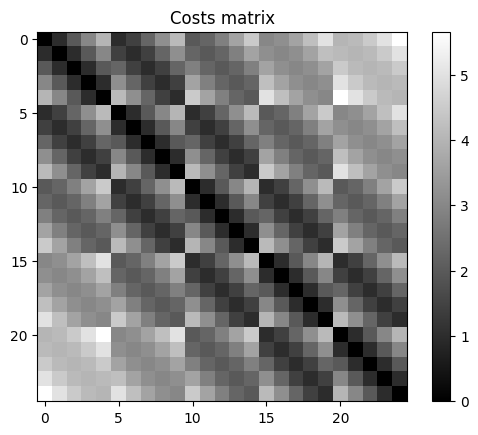

In [158]:
fig = plt.imshow(C, cmap='gray')
plt.title('Costs matrix')
plt.colorbar(fig)

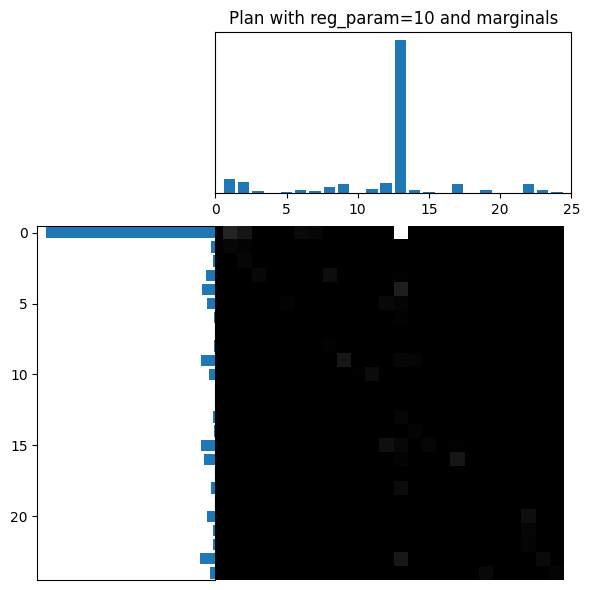

In [159]:
plt.figure(figsize=(6,6))
plot1D_mat_bar(im1_new.flatten(), im2_new.flatten(), plan, 'Plan with reg_param=10 and marginals')

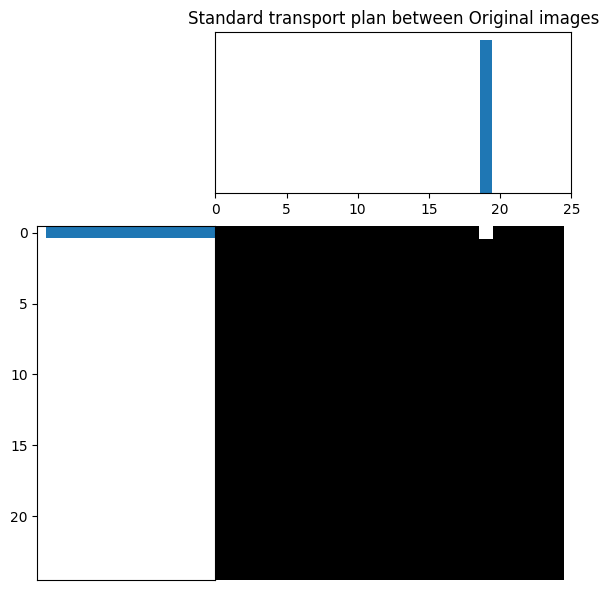

In [207]:
plt.figure(figsize=(6,6))
plot1D_mat_bar(im1.flatten(), im2.flatten(), plan_normal, 'Standard transport plan between Original images')

Something weird is happening with this plan, since the maximal value in the trivial plan is 0.164 instead of 1

Maybe we should normalize the matrix so it would sum up to something? I'm not sure how to adress this

In [174]:
plan_normal.max()

0.16484071454660568

In [175]:
temp = 1 / plan_normal.max()

In [178]:
temp

6.066462419496904

## 20x20 images

In [102]:
im1 = np.zeros([20,20])
im1[0:4,0:4] = 1
im2 = np.zeros([20,20])
im2[4:8,8:12] = 1

In [103]:
#Noise the images
im1_noisy = noise_image(im1, 5e-2)
im2_noisy = noise_image(im2, 5e-2)
#Split into pos and neg
im1_pos, im1_neg = split_signed_measure(im1_noisy.flatten())
im2_pos, im2_neg = split_signed_measure(im2_noisy.flatten())
#Take the split of mu_+ + nu_- and nu_+ + mu_-
im1_new = (im1_pos + im2_neg).reshape(im1.shape)
im2_new = (im1_neg + im2_pos).reshape(im2.shape)

In [104]:
C = calculate_costs(im1.shape)

In [105]:
plan = ot.unbalanced.mm_unbalanced(a = im1_new.flatten(), b = im2_new.flatten(), M = C, reg_m = 10)

In [106]:
plan_normal = ot.unbalanced.mm_unbalanced(a = im1.flatten(), b = im2.flatten(), M = C, reg_m = 1)

### Vizualizations

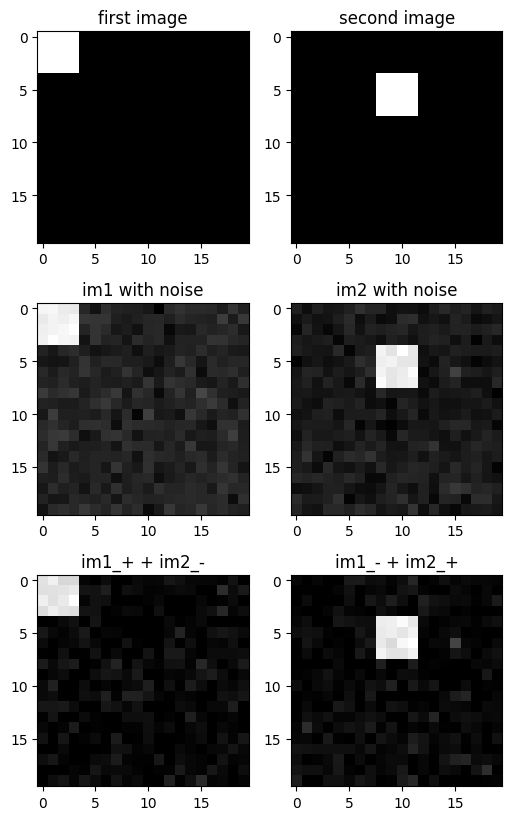

In [107]:
fig = plt.figure(figsize=(6, 10))

fig.add_subplot(3, 2, 1)
plt.title('first image')
plt.imshow(im1, cmap='gray')

fig.add_subplot(3, 2, 2)
plt.title('second image')
plt.imshow(im2, cmap='gray')

fig.add_subplot(3, 2, 3)
plt.title('im1 with noise')
plt.imshow(im1_noisy, cmap='gray')

fig.add_subplot(3, 2, 4)
plt.title('im2 with noise')
plt.imshow(im2_noisy, cmap='gray')

fig.add_subplot(3, 2, 5)
plt.title('im1_+ + im2_-')
plt.imshow(im1_new, cmap='gray')

fig.add_subplot(3, 2, 6)
plt.title('im1_- + im2_+')
plt.imshow(im2_new, cmap='gray')

In [108]:
a = im1_new.flatten()
b = im2_new.flatten()
M = C

@interact(reg_m=FloatSlider(min=0.5, max=10.0, step=0.1, value=10), a=fixed(a), b=fixed(b), M=fixed(M))
def interactive_UOT(reg_m=10):
    plan = ot.unbalanced.mm_unbalanced(a=a, b=b, M=M, reg_m=reg_m)
    fig = plt.imshow(plan, cmap='gray')
    plt.title('interactive reg_param')
    plt.colorbar(fig)
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='reg_m', max=10.0, min=0.5), Output()), _dom_classes…

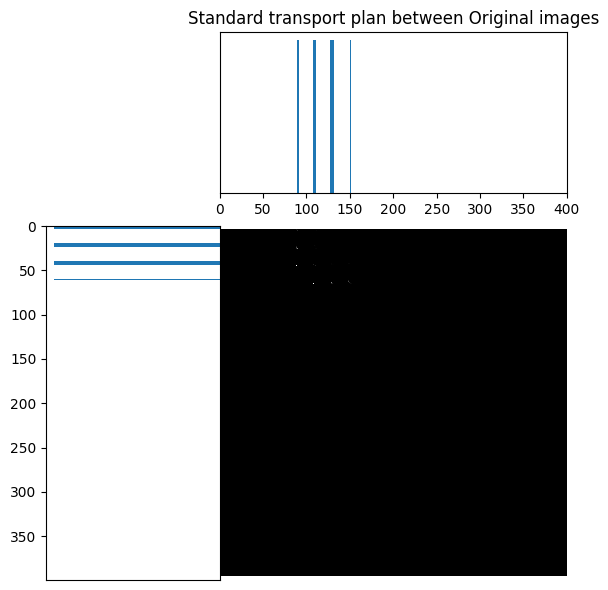

In [109]:
plt.figure(figsize=(6,6))
plot1D_mat_bar(im1.flatten(), im2.flatten(), plan_normal, 'Standard transport plan between Original images')

In [110]:
plt.imsave("20X20im.png", plan_normal, cmap="gray")